<a href="https://colab.research.google.com/github/dmachlanski/iads-summer-school-causality-2022/blob/main/labs/Tutorial_Sodium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference - Tutorial

We are going to combine our knowledge of regression and classification methods to estimate causal effects in observational data.

Steps we are going to take:
1. Problem description.
2. Importing packages.
3. Loading and exploring the data.
4. Data pre-processing.
5. Training the models.
6. Performance evaluation.
7. Model selection (optional).

## Step 1 - problem setting



This is a simplified version of a model that simulates the effect of sodium intake on blood pressure. Officially proposed in ([Luque-Fernandez et al. 2019](https://academic.oup.com/ije/article/48/2/640/5248195)).


We are given three covariates: age (A), sodium (S), and blood pressure (B). We are interested in the effect of sodium intake on blood pressure. In addition, we know that age affects both variables - confounder. Here is the assumed causal graph:

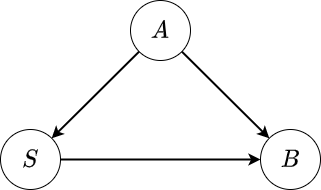

The code that implements the simulation can be found in [sodium_generate.py](https://github.com/dmachlanski/iads-summer-school-causality-2022/blob/main/labs/sodium_generate.py) script. This data generation process can be also described as follows:

$$A = \mathcal{N}(65, 5)$$ \\
$$
S=
    \begin{cases}
        1 & \text{ if } A/18 + \mathcal{N}(0, 1) > 3.5 \\ 
        0 & \text{ otherwise } 
    \end{cases}
$$ \\
$$B = ATE \times S + 2 A + \mathcal{N}(0, 1)$$ \\
$$ATE = 1.05$$

Note we assume the same effect across the entire population and fix it to an arbitrary scalar.

With this setting, we generate 10,000 samples and obtain file [sodium_10k.npz](https://github.com/dmachlanski/iads-summer-school-causality-2022/blob/main/labs/data/sodium_10k.npz).

Because we know the true ATE used in the data generation process, we can evaluate our models' performance by measuring how close their predicted ATE ($\widehat{ATE}$) is to the true one. More formally, we can write ATE as:

$$ATE = \mathbb{E}[\mathcal{Y}_1 - \mathcal{Y}_0]$$

And predicted ATE as:

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}(\hat{y}_1^{(i)} - \hat{y}_0^{(i)})$$

Where $\hat{y}_t^{(i)}$ denotes predicted potential outcome for treatment $t$ and individual $(i)$. We can thus see that ATE is essentially the average of individual treatment effects.

One commonly used metric that we will use here measures the absolute difference between the predicted and true ATE, that is:

$$\epsilon_{ATE} = \left| \widehat{ATE} - ATE \right|$$

We can implement this metric as the following function:

In [ ]:
def ate_error(pred_te, true_ate):
  """
  pred_te - collection of ITEs (list or array).
  true_ate - true ATE (scalar)
  """
  return np.abs(np.mean(pred_te) - true_ate)

## Step 2 - packages

Google Colab has loads of pre-installed packages already. What if we need more? We can install additional packages by knowing that:
- The exclamation mark ('!') gives us access to the Linux command line that runs behind our notebook.
- We can access the default python's package manager with the command 'pip'.

In our case, we are interested in using the [EconML](https://econml.azurewebsites.net/index.html) package, which is not part of the default Colab environment. We can install it via the following command:

In [ ]:
!pip install econml

Note this command has to be executed everytime you restart the notebook.

Now, we can import anything we need from EconML, together with the rest of the packages we need.

In [ ]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

## Step 3 - data

We are dealing here with the '.npz' file format. In order to access the data, the file can be either manually uploaded to Colab, or downloaded via the following command:

In [ ]:
!wget https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/sodium_10k.npz

Let's load the file with numpy's 'load' function

In [ ]:
data = np.load('sodium_10k.npz')

We can see what variable names are available by examining the 'files' property.

In [ ]:
data.files

Variable names:
- X -> A (age; background variable)
- T -> S (sodium intake; treatment variable)
- Y -> B (blood pressure; outcome variable)


In [ ]:
for f in data.files:
  print(f'{f}: {data[f].shape}')

As we can see above, we have three single-dimensional vectors, each of which consisting of 10,000 samples. We are going to reshape them to 2D vectors as some methods prefer this representation of data, though we will have to switch back and forth between 1D and 2D representation often as this requirement varies across methdos.

In [ ]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)

Let's plot the distributions of all three.

In [ ]:
bins=20
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
plt.show()

X and Y clearly follow the shape of the normal distribution, as expected. T is binary, i.e., consists of 0 and 1 values.

## Step 4 - data pre-processing

In [ ]:
x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(X, T, Y, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

## Step 5 - training

We are going to use three estimators here:
- Random forest (RF; regressor).
- Random forest with Inverse Propensity Weighting (IPW).
- X-learner with RF as base learners.

### Random Forest

#### Description

With random forests we simply model $P(Y|X, T)$, that is, we regress Y on X and T. Once trained, the model predicts potential outcomes $\hat{y}_t^{(i)}$. Thus, to obtain ITE predictions for each individual, we need to predict both $\hat{y}_0$ and $\hat{y}_1$, that is, predict the outcomes for both control and treated settings for each individual.

By calculating the difference between the treated and control outcome, we can obtain the effect per given individual. In other words:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

#### Usage

In [ ]:
# Random Forest
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Training predictions:
# Predict Y_0 given [X, 0]
rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
# Predict Y_1 given [X, 1]
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

# Test predictions (model's generalisation to unseen examples):
# Predict Y_0 given [X, 0]
rf_y0_out = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
# Predict Y_1 given [X, 1]
rf_y1_out = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

# Compute ITEs (training and test)
# ITE = Y_1 - Y_0
rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

### Random Forest with IPW

#### Description

This is a similar approach to the previous one, but extends it further with the Inverse Propensity Weighting (IPW). We proceed as follows:

1. Use random forest classifier to model unit's probability of receiving the treatment, that is, $P(t_i|x_i)$. Input: X, target: T. Note this is classic binary classification problem. $P(t_i|x_i)$ is called a **propensity score**.
2. Use trained classifier to predict propensity scores for each individual. Compute weights per each sample as:

$$w_i = \frac{t_i}{P(t_i|x_i)} + \frac{1-t_i}{1-P(t_i|x_i)}$$

Intuition: Dominant group gets smaller weights. In practice, gives more importance to treated samples.

3. Use sample weights in random forest regressor training.
4. Proceed with predictions as in the previous section.

We can compute the sample weights with the following function:

In [ ]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  return ti / ptx + ((1.0 - ti) / (1.0 - ptx))

#### Usage

In [ ]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

# Make predictions
rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out

### X-learner

#### Formal description

A meta-learner implemented via EconML. Uses provided regressors and classifiers to solve smaller sub-problems. Models the effect directly instead of the outcomes, predicting ITEs as a consequence.

Originally introduced in [(Künzel et al. 2019)](http://arxiv.org/abs/1706.03461). The modelling process of the X-learner can be divided into three stages.

**Stage 1**

Use provided regressors to model $\mathcal{Y}_0$ and $\mathcal{Y}_1$ separately. More formally, the response functions are:

$$\mu_0(x) = \mathbb{E}[\mathcal{Y}_0|X=x]$$
$$\mu_1(x) = \mathbb{E}[\mathcal{Y}_1|X=x]$$

We denote estimated functions as $\hat{\mu}_0$ and $\hat{\mu}_1$.

**Stage 2**

Define imputed treatment effects as:

$$\mathcal{D}_0^{(i)} = \hat{\mu}_1(X_0^{(i)}) - \mathcal{Y}_0^{(i)}$$
$$\mathcal{D}_1^{(i)} = \mathcal{Y}_1^{(i)} - \hat{\mu}_0(X_1^{(i)})$$

Use provided regressors to model $\mathcal{D}_0$ and $\mathcal{D}_1$ separately. The response functions are formally defined as:

$$\tau_0(x) = \mathbb{E}[\mathcal{D}_0|X=x]$$
$$\tau_1(x) = \mathbb{E}[\mathcal{D}_1|X=x]$$

We denote estimated functions as $\hat{\tau}_0$ and $\hat{\tau}_1$.

**Stage 3**

The final treatment effect estimate is a weighted average of the two estimates from Stage 2:

$$\hat{\tau}(x) = g(x)\hat{\tau}_0(x) + (1 - g(x))\hat{\tau}_1(x)$$

Where $g \in [0, 1]$ is a weight function. In practice, $g$ can be modelled as a propensity score function $e$, formally written as:

$$e(x) = \mathbb{E}[T|X=x]$$

Using a provided classifier, we can obtain an estimate $\hat{e}$ that can be used in place of $g$. That is:

$$\hat{\tau}(x) = \hat{e}(x)\hat{\tau}_0(x) + (1 - \hat{e}(x))\hat{\tau}_1(x)$$

In summary, we perform the following steps:
1. Training (inputs: X, T, Y; outputs: $\hat{\tau}_0$, $\hat{\tau}_1$, $\hat{e}$):
  1. Model the outcomes with a provided regressor class and obtain estimators $\hat{\mu}_0$ and $\hat{\mu}_1$.
  2. Make predictions $\hat{\mu}_1(X_0^{(i)})$ and $\hat{\mu}_0(X_1^{(i)})$.
  3. Compute imputed treatment effects $\mathcal{D}_0$ and $\mathcal{D}_1$.
  4. Model the imputed treatment effects with a provided regressor class and obtain estimators $\hat{\tau}_0$ and $\hat{\tau}_1$.
  5. Model the propensity scores with a provided classifier class and obtain an estimator $\hat{e}$.
2. Prediction (inputs: X; outputs: $\widehat{ITE}$):
  1. Use estimator $\hat{\tau}$ to obtain individual treatment effect estimates.

#### Usage

We continue with random forests here by providing the X-learner with RF regressor and RF classifier as base learners. Note it distinguishes X from T in its input - it is necessary to learn the propensity score estimator. Also, the final prediction does not depend on T! Though it does indirectly by predicting the propensity score internally.

In [ ]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_in = xl.effect(x_train)
xl_te_out = xl.effect(x_test)

## Step 6 - evaluation

We will examine our estimators' performance from different perspectives:
- ATE error
- Confidence intervals of predicted ATEs
- Visualisations of predicted effects

### ATE error

In [ ]:
true_ate = 1.05

rf_ate_in = ate_error(rf_te_in, true_ate)
rf_ate_out = ate_error(rf_te_out, true_ate)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, true_ate)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, true_ate)

xl_ate_in = ate_error(xl_te_in, true_ate)
xl_ate_out = ate_error(xl_te_out, true_ate)

In [ ]:
results = []
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPW)', rf_ipsw_ate_in, rf_ipsw_ate_out])
results.append(['XL', xl_ate_in, xl_ate_out])

cols = ['Method', 'ATE train', 'ATE test']

df = pd.DataFrame(results, columns=cols)
df

### Confidence intervals

In [ ]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [ ]:
rf_ate_bounds = mean_ci(rf_te_out)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_out)
xl_ate_bounds = mean_ci(xl_te_out)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

### Visualisations

In [ ]:
plt.figure()
plt.boxplot([rf_te_out, rf_ipsw_te_out, xl_te_out.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, rf_te_out, label="RF", s=m_size)
plt.scatter(x_test, rf_ipsw_te_out, label="RF (IPW)", s=m_size)
plt.scatter(x_test, xl_te_out, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

## Step 7 - model selection

So far, we have used regressors and classifiers with default hyperparameters. In real experiments and applications, you will likely want to optimise your estimators at least to some extent.

In [ ]:
# Defines parameter search space for Random Forests.
params = {"max_leaf_nodes": [10, 20, 30, None], "max_depth": [5, 10, 20, None]}

### Random Forest

In [ ]:
rf = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)

rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_y0_out = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_y1_out = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

### Random Forest with IPW

In [ ]:
prop_clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)
weights = get_ps_weights(prop_clf, x_train, t_train)

rf_ipsw = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
rf_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out

### X-Learner

In [ ]:
reg = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)

xl = XLearner(models=reg, propensity_model=clf)
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_in = xl.effect(x_train)
xl_te_out = xl.effect(x_test)

### Evaluation

In [ ]:
true_ate = 1.05

rf_ate_in = ate_error(rf_te_in, true_ate)
rf_ate_out = ate_error(rf_te_out, true_ate)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, true_ate)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, true_ate)

xl_ate_in = ate_error(xl_te_in, true_ate)
xl_ate_out = ate_error(xl_te_out, true_ate)

results = []
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPW)', rf_ipsw_ate_in, rf_ipsw_ate_out])
results.append(['XL', xl_ate_in, xl_ate_out])

cols = ['Method', 'ATE train', 'ATE test']

df = pd.DataFrame(results, columns=cols)
df